In [39]:
%load_ext autoreload
%autoreload 2
import numpy as np
import control

H = np.array([[0, 8, 16], [1, 9, 17], [2, 10, 18], [3, 11, 19], [4, 12, 20]])
# print(H)


lst = np.array([[0], [1], [2], [3], [4]])

lambdachoice = np.array([[0, 1]])

lambdatimesG = np.linalg.pinv(lst) @ H

G = np.linalg.pinv(lambdachoice) @ lambdatimesG

# print(np.exp(H) - np.exp(lst @ lambdachoice @ G))

def linearSys(N, x0):
    '''Return data for N instances of linear system evolution'''
    A = np.array([[-0.99, -2, 3, 1], [0, 0.95, -1, 0.8], [0, 0, 0.96, -0.7], [0, 0, 0, -0.99]])/1.05
    
    
    C = np.zeros((2,4))
    C[0,0] = 1.0
    C[1,1] = 1.0
    
    x = np.empty((4, N+1))
    x[:,0] = x0.flatten()
    y = np.empty((2, N+1))
    y[:,0] = (C @ x0).flatten()
    
    for i in range(N):
        x[:,i+1] = A @ x[:,i]
        y[:,i+1] = C @ x[:,i+1]
        
        
    # print(np.linalg.matrix_rank(control.obsv(A, C)))
    # print(np.linalg.eigvals(A))
    return y
x0 = np.array([[10],[-3], [5], [2]]) 

X = np.empty((3, 2, 11))
X[0,...] = linearSys(10, x0)
X[1,...] = linearSys(10, 2*x0)
X[2,...] = linearSys(10, 3*x0)

print(X[0,...])
methods.compute_Korda2020(X, 2, f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[ 10.          12.47619048   7.03038549  25.98398445   3.67797294
   35.51927188   0.25280159  41.96615301  -3.03696435  46.02755038
   -6.0588029 ]
 [ -3.          -5.95238095  -9.90612245 -11.62489148 -14.33866765
  -15.15884449 -16.94647386 -17.12441826 -18.22786166 -17.95843685
  -18.56332077]]
Computing linear evolution in data to find initial states on nonrecurrent set
Computed eigenfunction, eigenvalue pairs in 0.7 ms
[[ 10.          12.47619048   7.03038549  25.98398445   3.67797294
   35.51927188   0.25280159  41.96615301  -3.03696435  46.02755038
   -6.0588029   20.          24.95238095  14.06077098  51.9679689
    7.35594589  71.03854376   0.50560319  83.93230601  -6.07392871
   92.05510075 -12.1176058   30.          37.42857143  21.09115646
   77.95195335  11.03391883 106.55781563   0.75840478 125.89845902
   -9.11089306 138.08265113 -18.17640871]
 [ -3.          -5.95238095  -9.9061224

(array([[ 1.40374158e-19-4.17188433e-19j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,  1.40374158e-19+4.17188433e-19j,
          0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         -7.86468922e-17+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  3.90695209e-18+0.00000000e+00j]]),
 array([[1., 1., 0., 0.],
        [0., 0., 1., 1.]]),
 <function methods.compute_Korda2020.<locals>.optimal_lift(X)>)

In [3]:
# Test MUSIC algorithm, originating as a source-finding algorithm for multiple independent frequence sources

N = 101
x0 = np.array([[10],[-3], [5], [2]]) 

H = linearSys(N, x0).T
# print(H)

# Compute auto-correlation matrix and eigendecomposition
Rx = H @ H.T
w, v = np.linalg.eig(Rx)
# Assume 4 sources
N_g = 4

idx = w.argsort()[::-1]
# print(w)
eig_sorted = w[idx]
vec_sorted = v[:, idx]

# Compute error matrix using noise eigenvectors
En = vec_sorted[:,N_g:]

def A_lambda(exponent):
    return np.vander(np.array([np.exp(exponent)]), N+1, increasing=True).T

# A_lambda = lambda lam : np.vander(np.array([np.exp(lam)]), N+1, increasing=True).T
P = lambda lam : 1 / (A_lambda(lam).conj().T @ En @ En.conj().T @ A_lambda(lam)).real

[-0.94285714  0.9047619   0.91428571 -0.94285714]


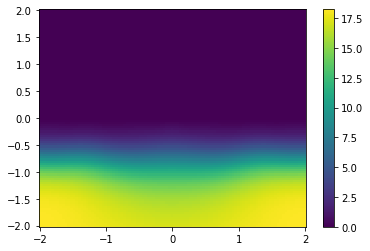

In [120]:
import matplotlib.pyplot as plt

# print(A_lambda(np.array([0,1])))

# Generate data
x = np.linspace(-2, 2, N)
y = x.copy()
X,Y = np.meshgrid(x,y)

Z = np.empty((N,N), dtype=complex)
for i in range(N):
    for k in range(N):
        Z[i,k] = P(x[i] + y[k]*1j)

cs = plt.pcolor(X,Y,np.absolute(Z))
plt.colorbar(cs)
plt.show()

In [4]:
import utils
N = 500
N_t = 10
H = np.empty((N+1, N_t))
n = 4
for i in range(N_t):
    H[:,i] = linearSys(N, np.random.rand(4))

U, S, V = np.linalg.svd(H, full_matrices=False)

# Estimate of eigenvalues using individual trajectories
print(S[:n])

# Estimate using time-delay coordinates
# H_test = np.array([[1, 2, 3,4, 5, 6, 7]])

H_test = H[:,0].reshape((1,N+1))
H_test_comp = utils.MakeHankelMatrix(H_test, 8)
H_test2 = H[:,1].reshape((1,N+1))
h_test_comp2 = utils.MakeHankelMatrix(H_test2, 8)

U2, S2, _ = np.linalg.svd(H_test_comp, full_matrices=False)
print(S2[:n])

U3, S3, _ = np.linalg.svd(h_test_comp2, full_matrices=False)

print(U[0,:n])
print(U2[0,:n])


print("Evolution matrices")

print( np.linalg.pinv(U[:N-1, :n]) @ U[1: N, :n])
print( np.linalg.pinv(U2[:7, :n]) @ U2[1: 8, :n])

s, _ = np.linalg.eig( np.linalg.pinv(U[:N-1, :n]) @ U[1: N, :n])#, full_matrices = False ) 
s2, _ = np.linalg.eig( np.linalg.pinv(U2[:7, :n]) @ U2[1: 8, :n])#, full_matrices = False ) 
s3, _ = np.linalg.eig( np.linalg.pinv(U3[:7, :n]) @ U3[1: 8, :n])#, full_matrices = False ) 
print(s)
print(s2)
print(s3)
V = np.vander(s, N+1, increasing=True).T

G = np.linalg.pinv(V) @ H

# Regularised Least squares
rho = 1
G_reg = np.linalg.inv(V.T @ V + rho * np.eye(4)) @ V.T @ H
print(V.shape)
print(G.shape)

print("Estimate for G")
print(G_reg)

print("Difference between measurement sequence and vandermonde estimate")
print(np.mean(H - V @ G))
print(np.mean(H - V @ G_reg))

[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[-0.94285714  0.9047619   0.91428571 -0.94285714]
[125.51100878  29.53834853   2.70655953   0.57117158]
[65.55930394 43.96258182  6.68675853  5.00213131]
[-0.01524615  0.02277216  0.19055771  0.64974027]
[-0.35838379 -0.28326757 -0.66313259  0.25718265]
Evolution matrices
[[-0.93718094 -0.34219503  0.02377018  0.03937922]
 [-0.34102972  0.93387846  0.08852242 -0.06088684]
 [-0.0707035   0.00845707 -0.65343895 -0.47369971]
 [-0.01261697  0.10091332 -0.72684528  0.59007477]]
[[-0.96624972  0.36531389  0.31140939  0.18534122]
 [ 0.15335956  0.9560

We define for the least-squares optimisation problem $\| Y - \Lambda G \|$ another optimisation problem with rank constraint. The matrix $G$ is arbitrary $N_g \times N_t$, but $\Lambda$ has structure
$$ \Lambda = \begin{bmatrix} 1 & 1 & \cdots \\ \lambda_1 & \lambda_2 & \cdots \\ \lambda_1^2 & \lambda_2^2 & \cdots \\ \vdots & \vdots & \ddots \end{bmatrix}.$$
Defining $D_\lambda = \text{diag}(\lambda_1, \lambda_2, \dots)$, and $\overline \Lambda$ as the matrix $\Lambda$, but shifted one place up, we obtain that $\overline \Lambda = \Lambda D_{\lambda}$. These relationships can be written in terms of a rank constraint, for which we introduce
$$ H = \begin{bmatrix} \hat M & \Lambda & \overline \Lambda \\ \hat G & I_{N_g} & D_\lambda \end{bmatrix}. $$

By the Schur decomposition, the rank of the matrix $Y - \Lambda I_{N_g} G$ is equivalent to rank of the left $2 \times 2$ block submatrix of $H$. Similarly, the introduced relationship between $\Lambda$ and its shifted matrix $\overline \Lambda$, gives the latter columns the same rank. Hence we obtain the optimisation problem
$$ \min \| Y - \hat M \| $$
subject to $\text{rank}(H) = N_g$


In [23]:
import methods
import Dictionaries
import cvxpy as cvx
import numpy as np

def linearSysFull(N, x0):
    '''Return data for N instances of linear system evolution'''
    A = np.array([[-0.99, -2, 3, 1], [0, 0.95, -1, 0.8], [0, 0, 0.96, -0.7], [0, 0, 0, -0.99]])/1.05
    
    
    C = np.zeros((1,4))
    C[0,0] = 1.0
    
    x = np.empty((4, N+1))
    x[:,0] = x0.flatten()
    y = np.empty((1, N+1))
    y[:,0] = C @ x0
    
    for i in range(N):
        x[:,i+1] = A @ x[:,i]
        y[:,i+1] = C @ x[:,i+1]
        
    return x


def H_Theta(Mhat, ThetaHat, ThetaHatShift, Xhat, Id, Lhat):
    return cvx.bmat([[Mhat, ThetaHat, ThetaHatShift], [Xhat, Id,Lhat]])

def H_Theta_num(M, Theta, ThetaShift, X, Id, L):
    '''Numerical implementation for H_Theta'''
    return np.block([[M, Theta, ThetaShift], [X, Id, L]])

N = 20
N_t = 10
n = 4
H = np.empty((N_t, n, N))
N_g = 3
for i in range(N_t):
    H[i,...] = linearSysFull(N-1, np.random.rand(4))

# Collect trajectories of single measurement variable, formatted as in Korda2020
# Y = H[:,0,:].T
# Define Y as decomposed product
Y = np.vander([0.99, 0.95, 1.01], N, increasing=True).T @ np.random.rand(N_g, N_t) 
print(Y)

U_j = [np.zeros((N + N_g, N_g))]
V_j = [np.zeros((N_t + 2 * N_g, N_g))]

# Initialise CVX optimisation problem
Mhat = cvx.Variable(Y.shape)
Xhat = cvx.Variable((N_g, N_t))
ThetaHat = cvx.Variable((N,N_g))
ThetaHatShift = cvx.Variable((N, N_g))
Id = np.eye(N_g)
Lhat = cvx.diag(cvx.Variable(N_g, complex=False)) #, diag = False) # diag = True
cons = [ThetaHat[0,:] == np.ones((N_g,)), ThetaHat[1:,:] == ThetaHatShift[0:-1,:], ThetaHat[1,:] == cvx.diag(Lhat)]

# Construct rank constraint matrix
Fullmatrix = H_Theta(Mhat, ThetaHat, ThetaHatShift, Xhat, Id, Lhat)

U = cvx.Parameter((N + N_g, N_g))
V = cvx.Parameter((N_t + 2 * N_g, N_g))
rho = cvx.Parameter(pos=True)

# Define objective function and problem handle
obj = cvx.norm(Y - Mhat,2) + rho * ( cvx.norm(Fullmatrix, "nuc") - (cvx.trace(U.T @ Fullmatrix @ V)))
prob = cvx.Problem(cvx.Minimize(obj), cons)

# rho = 1
i = 0
eps = 1
rho_new = 1
mu = 2
rho_max = 100
while eps > 1e-10 and i < 10:
    rho_new = min(mu * rho_new, rho_max)
    # Set CVX problem parameters
    rho.value = rho_new
    U.value = U_j[i]
    V.value = V_j[i]
    
    prob.solve(verbose=False)

    M = Mhat.value
    X = Xhat.value
    Theta = ThetaHat.value
    ThetaShift = ThetaHatShift.value
    L = Lhat.value 
    
    Res = Fullmatrix.value # H_Theta_num(M, Theta, ThetaShift, X, Id, L)
    
    U1, s, V1 = np.linalg.svd(Res, full_matrices=True)
    # print(s)
    
    U_j.append(U1[:,:N_g])
    V_j.append(V1[:,:N_g])
    
    eps = abs(obj.value - eps) / obj.value
    i = i + 1
    print(f'Iteration {i} completed with error {obj.value} and rho={rho_new}')
    print(np.diag(L))

print(np.diag(L))
print(Theta)
print(ThetaShift)
print(np.linalg.norm(Res, 'nuc'))
print(np.linalg.norm(Y - M, 2))
print(Res)

[[2.40819463 1.16853308 0.89160985 1.85736427 1.62071253 1.37332248
  1.50749223 1.71230054 1.56506528 1.23706185]
 [2.3633331  1.15912366 0.86265855 1.84568003 1.57610968 1.34647613
  1.50082994 1.69109659 1.54477864 1.23601811]
 [2.32067871 1.15060771 0.8350364  1.83474512 1.53393408 1.32138455
  1.4949444  1.67131767 1.52539162 1.23513451]
 [2.28012865 1.14294545 0.80867849 1.8245302  1.49406799 1.29796419
  1.48980366 1.65289899 1.50686504 1.23440911]
 [2.24158527 1.13609914 0.78352316 1.81500739 1.45639962 1.2761357
  1.48537738 1.63577901 1.48916167 1.2338401 ]
 [2.20495577 1.13003297 0.75951182 1.80615025 1.42082275 1.25582376
  1.4816368  1.6198993  1.47224611 1.23342576]
 [2.17015201 1.12471297 0.73658881 1.79793367 1.38723651 1.23695684
  1.47855465 1.60520442 1.45608474 1.23316448]
 [2.13709025 1.12010689 0.71470122 1.79033379 1.35554511 1.21946705
  1.47610505 1.5916417  1.44064561 1.23305473]
 [2.10569092 1.11618417 0.69379878 1.78332801 1.32565754 1.20328992
  1.47426348 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Key 'Generate' not found in system construction
Key 'Autonomous' not found in system construction
Using existing dataset at filepath
66


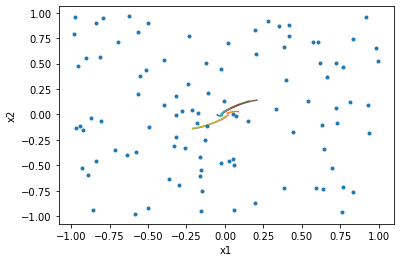

In [132]:
%load_ext autoreload
%autoreload 2
import System
import methods
import numpy as np
import Dictionaries
import matplotlib.pyplot as plt
def randomCirc(N, n, r = 0.02):
    '''Construct N initial conditions for random points on an n-d sphere of radius r'''
    # Normalised n-d Gaussian points result in a uniform point on a sphere
    
    random_Initialconditions = np.random.randn(N,n)
    return r * random_Initialconditions / np.linalg.norm(random_Initialconditions, axis=1).reshape((N,1))


KordaEquation = System.differentialEquation(System.forcedvanDerPolSystemKorda, 2, 1)
Korda = System.System(KordaEquation, 'testdata/Korda2020.mat', 150, 100, 0.01, Generate=False, Autonomous=True, Initialisation_function = randomCirc)

X = Korda.trainingData()
f = Dictionaries.thin_plate_rbf_dictionary(2, 100, 2)

plt.plot(Korda.StateSequence[0:10,0,:].T, Korda.StateSequence[0:10,1,:].T, '-', f.origins[:,0,:], f.origins[:,1,:], '.')
plt.xlabel("x1")
plt.ylabel("x2")
plt.savefig('figure1.png', dpi=400)
plt.show()

In [133]:
%reload_ext autoreload
# import methods
N_g = 4
A, f_opt = methods.compute_Korda2020(X, N_g, s = 5)

[[[ 0.91521466]
  [ 0.71034969]
  [ 0.55969399]
  [ 0.07047025]]

 [[ 0.7469894 ]
  [ 0.37067618]
  [-0.8849018 ]
  [-0.00605835]]]
[[1.73112053 2.27330607 1.11684558 1.52068151 2.01715306 2.0717281
  1.16974796 0.84001421 1.45482032 2.48655745 1.37424577 1.90781706
  2.35352709 1.89839396 1.36263583 1.17870278 2.13570101 1.78865106
  2.70715197 1.66078529 1.86551365 1.07980179 1.71046669 1.2469974
  0.4177083  2.19237878 1.00970379 2.17559608 2.42594518 1.66302524
  1.96358783 1.4500152  2.21585912 2.18541377 1.91639333 1.91755996
  1.76273507 2.09458822 1.30682291 1.45903544 1.70259595 1.41418899
  1.93232574 1.12406303 1.74432546 1.3743651  1.68048612 1.12124505
  1.93224785 1.40670312 1.24320238 1.83081927 0.91073625 2.05546167
  1.75711253 1.71165384 2.28221047 1.03103264 1.85989748 1.823448
  1.8749111  0.92176539 1.43173117 2.04771603 2.05296112 2.48672136
  1.92993139 1.34892791 2.11637014 0.62220922 1.94247946 1.48822724
  1.10853464 1.95208679 2.04838334 1.83818854 1.36308103

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Found relative residual in x0 of 0.088 %
Found relative residual in x1 of 0.123 %
(0.0004555508120233018-4.2522652947084935e-17j)
Computed eigenfunction, eigenvalue pairs in 272.6 ms
Starting computation of linear evolution surface from data


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Computed eigenfunction surface in 280.2 ms


Lifting dynamics
(8, 1)
1


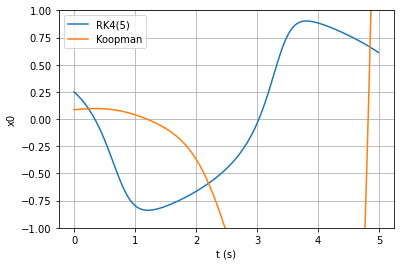

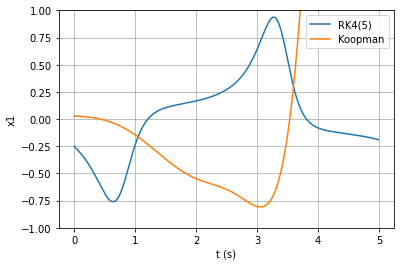

In [136]:
import plot_data
x0 = np.array([0.25, -0.25])
u = np.zeros((1,500))
B = np.zeros((2 * N_g, 1))
# print(B.shape)
# print(A.shape)
# print(A)
# print(C.shape)
# print(C)

# print(f_opt(x0.T))

t_out, y_est, y_comp = methods.linear_compare(A, B, Korda, f_opt, 0, x0, u)

plot_data.compareTrajectories(t_out, y_comp, y_est.real, Names=["RK4(5)", "Koopman"])

In [24]:
def H_Theta(M, Thetahat, ThetaHatShift, Xhat, Id, Lhat):
    return np.block([[Mhat, ThetaHat, ThetaHatShift], [Xhat, Id,Lhat]])

Mhat = cvx.Variable(Y.shape)
Mhat = np.ones(Y.shape)
Xhat = np.ones((N_g, N_t))


Xhat = np.ones((N_g, N_t))
ThetaHat = np.ones((N,N_g))
ThetaHatShift = np.ones((N, N_g))
Id = np.eye(N_g)
Lhat = np.eye(N_g)
cons = [ThetaHat[0,:] == np.ones((N_g,))]

rho = 1
i = 0
eps = 1
# while eps > 1e-2 and i < 100:
# Define objective function
Fullmatrix = H_Theta(Mhat, ThetaHat, ThetaHatShift, Xhat, Id, Lhat)
# print(Fullmatrix.ndim)
# print(Fullmatrix.shape)
obj = np.linalg.norm(Y - Mhat,2) + rho * ( np.linalg.norm(Fullmatrix, "nuc") - np.trace(U_j[i].T @ Fullmatrix @ V_j[i]) )
print(obj)
print(cons)
    

45.351528362699355
[array([ True,  True])]


[[-1.96881560e-04+2.90094144e-04j -3.91183720e-05+3.48115507e-04j
  -3.91183720e-05+3.48115507e-04j ...  5.90845267e-06-2.67451326e-04j
   8.72837532e-05+4.23605048e-04j  3.48913543e-04-2.37275630e-04j]
 [-3.09571810e-04+1.65181406e-04j -1.96881560e-04+2.90094144e-04j
  -1.96881560e-04+2.90094144e-04j ...  4.61883333e-04-4.68856067e-05j
  -1.13201029e-04+4.13018068e-04j -3.92679786e-04+1.48633713e-04j]
 [ 1.19057439e-05-4.63434200e-04j -3.09571810e-04+1.65181406e-04j
  -2.92550564e-04+2.22470368e-04j ... -1.16265409e-04+3.95388188e-04j
  -3.45833257e-04-2.47181900e-04j  2.78620254e-04+3.12253742e-04j]
 ...
 [-4.01302043e-04+1.30299991e-05j  1.38811191e-04-3.82783028e-04j
   5.67510406e-04-1.24140359e-05j ...  5.88623380e-04-2.28109279e-04j
   6.27649011e-04+7.22843860e-05j  6.27649011e-04+7.22843860e-05j]
 [ 1.32149631e-04-3.80546085e-04j -3.61730650e-04+1.92721514e-04j
   3.59211939e-04-3.21066605e-04j ...  4.14351388e-04-4.75571601e-04j
   5.88623380e-04-2.28109279e-04j  5.88623380e-

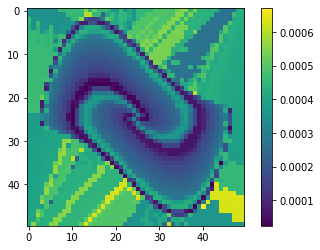

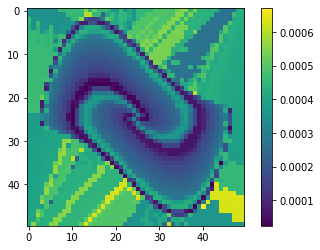

In [32]:
# 2d plot of optimal interpolated function
x = np.linspace(-1,1, 50)
y = np.linspace(-1,1, 50)
X_gr, Y_gr = np.meshgrid(x,y)
Z = np.empty((2 * N_g, 50,50), dtype=complex)
for i in range(50):
    for j in range(50):
        Z[:, i,j] = f_opt( np.hstack((X_gr[i,j], Y_gr[i,j]))).flatten()

plt.imshow(abs(Z[0,...]))
print(Z[0,...])
plt.colorbar()
plt.figure()
plt.imshow(abs(Z[1,...]))
plt.colorbar()

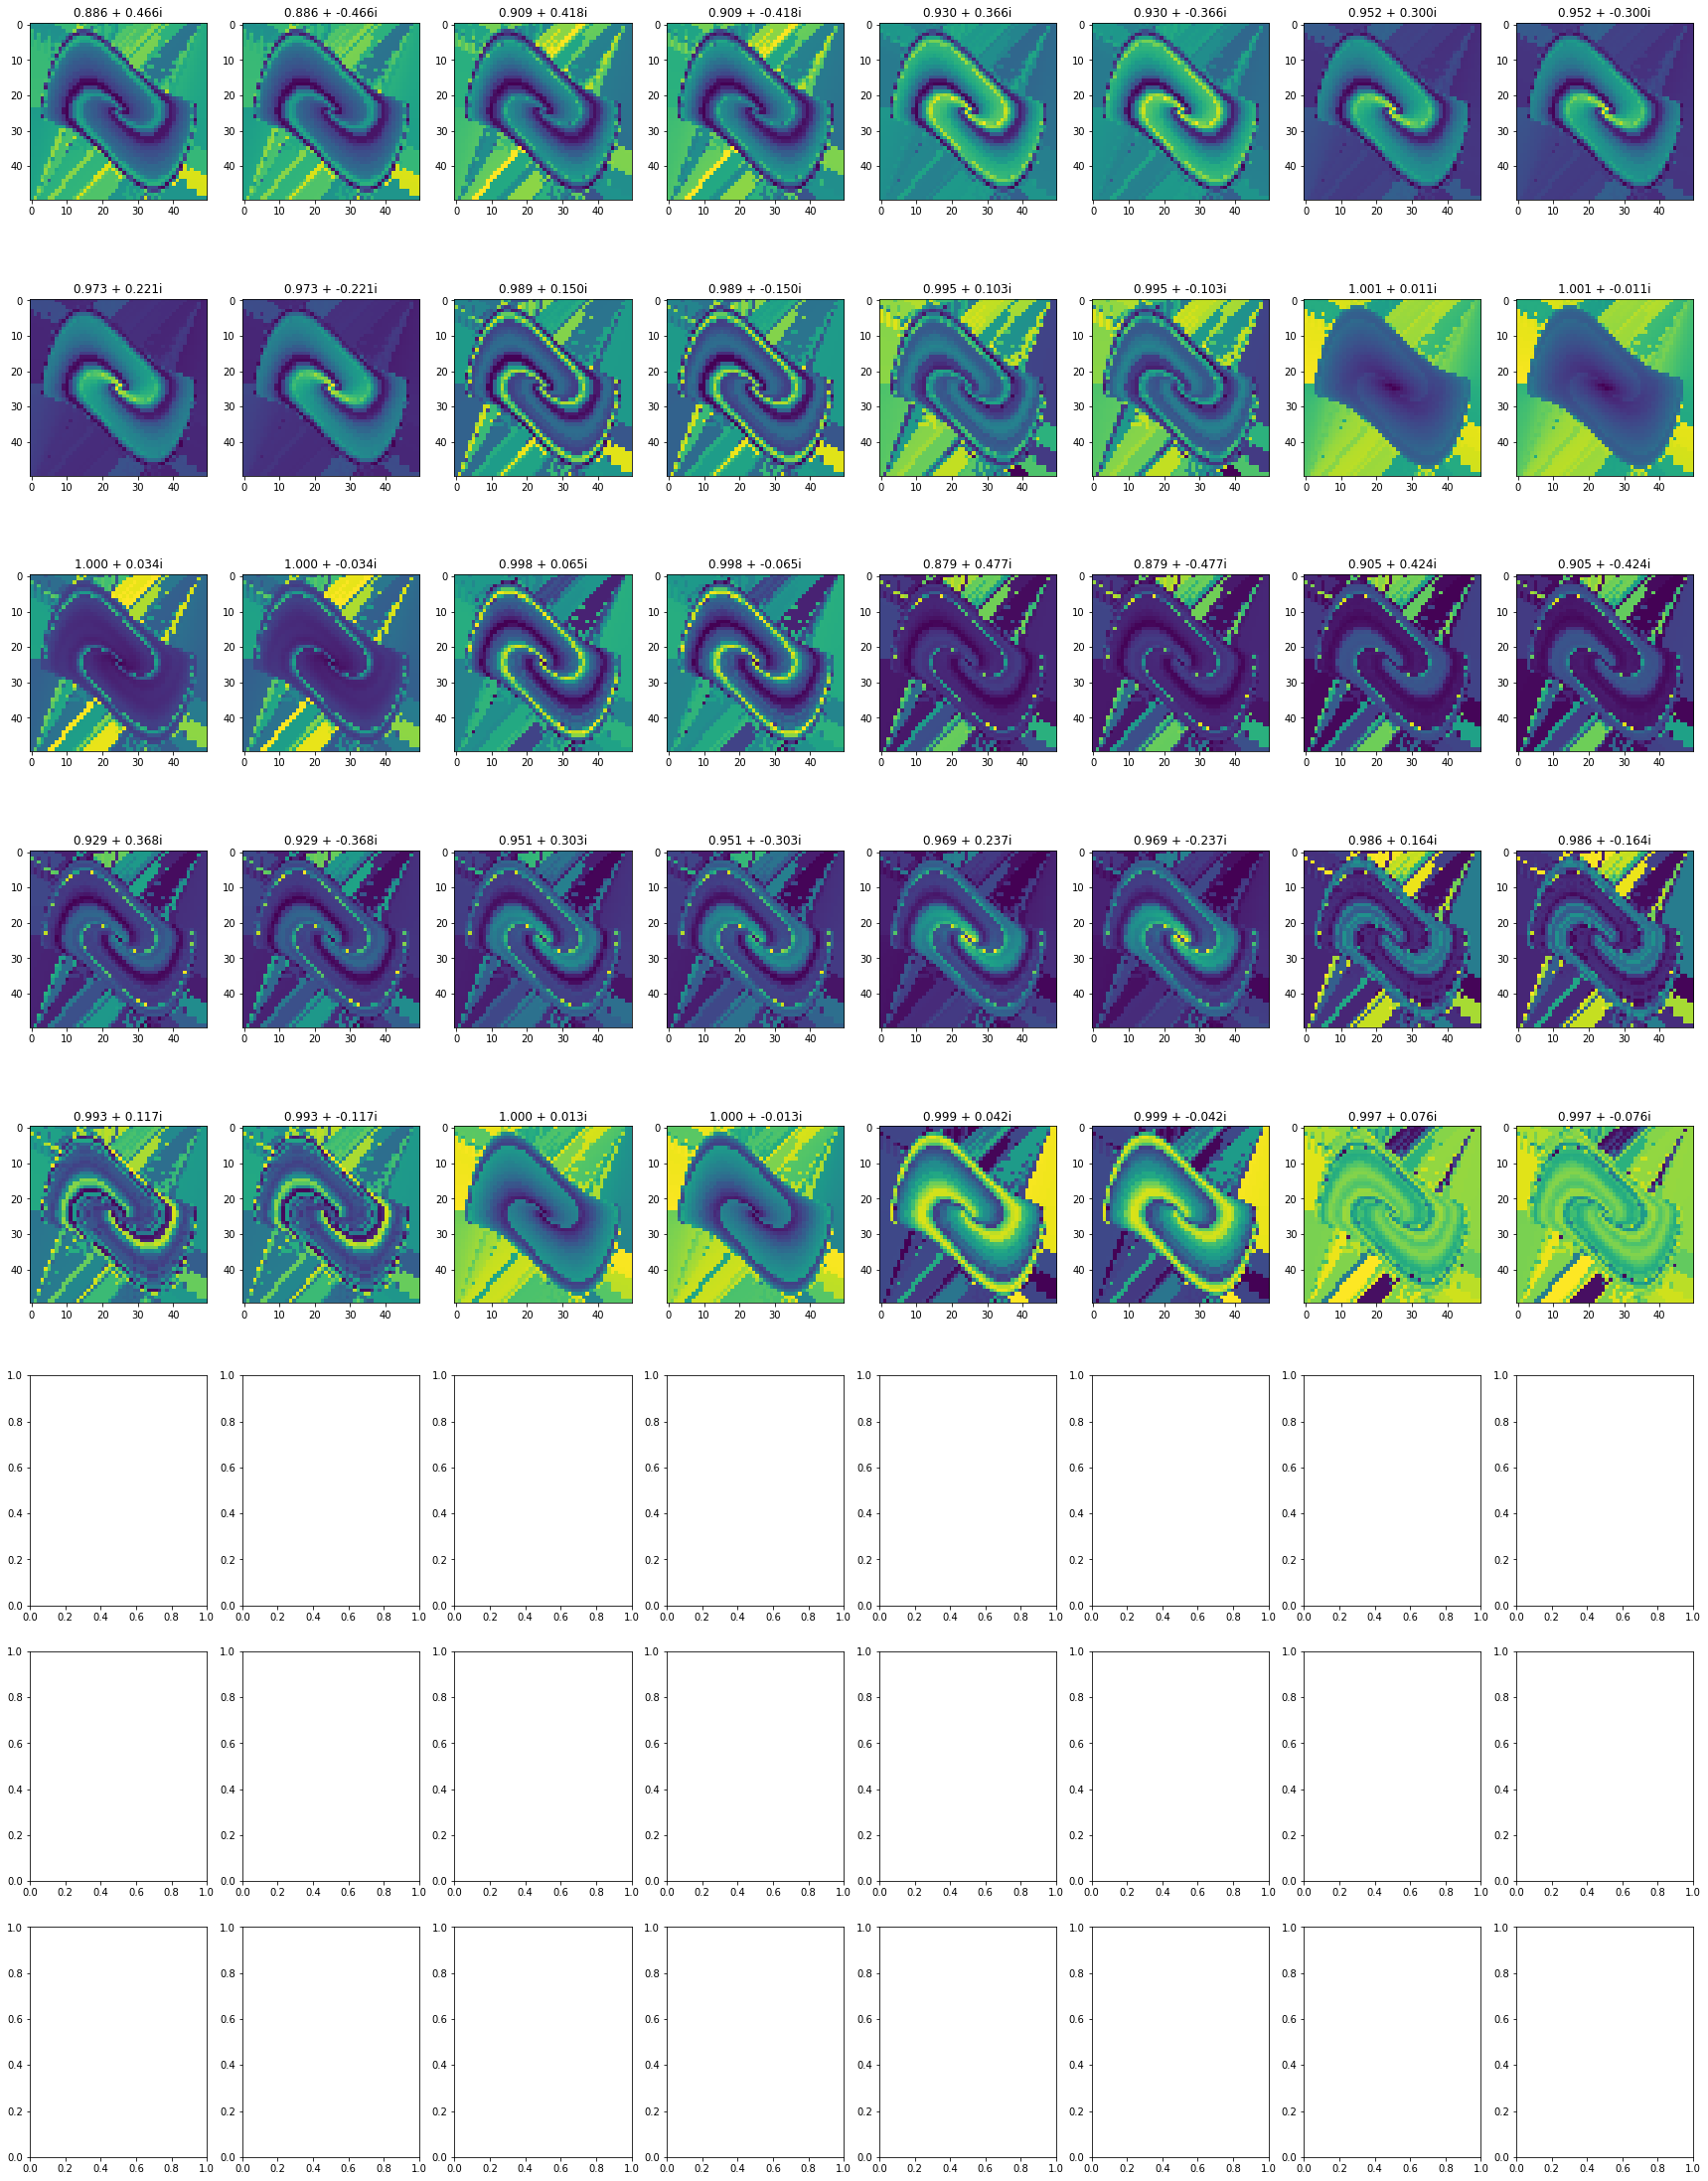

In [33]:
fig, axs = plt.subplots(8, 8, figsize=(30,40))


for i in range(2*N_g):
    # print(i // 8, i % 8)/
    # print(i % 8)
    axs[i // 8, i % 8].imshow(abs(Z[i,...]))
    axs[i // 8, i % 8].set_title('{0.real:.3f} + {0.imag:.3f}i'.format(A[i,i]))
    # axs[i // 12, i % 8].colorbar()

In [97]:
print(100*np.linalg.norm(y_comp[:,:100] - y_est2[:,:100].real, 2) / np.linalg.norm(y_comp[:,:100],2))

2.7570403670132793
